# First convolutions

## Objectives :
  - Recognizing traffic signs 
  - Understand the **principles** and **architecture** of a **convolutional neural network** for image classification
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them ! 

# Step 1 - Import and init

## 1.1 - Python stuff

In [16]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import keras

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os,time,sys

from importlib import reload

from sklearn.utils import shuffle

### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  
A 20% 24x24 dataset, with 5 epochs and a scale of 1, need  **3'30** on a CPU laptop.\
`fit_verbosity` is the verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch

In [17]:
enhanced_dir = './data'
# enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'

dataset_name  = 'set-24x24-L'
batch_size    = 64
epochs        = 5
scale         = 1
fit_verbosity = 1

## Step 2 - Load dataset
We're going to retrieve a previously recorded dataset.  
For example: set-24x24-L

In [18]:
def rescale_dataset(x_train, y_train, x_test, y_test, scale=1):
    n_train = int(len(x_train) * scale)
    n_test = int(len(x_test) * scale)

    return x_train[:n_train], y_train[:n_train], x_test[:n_test], y_test[:n_test]

In [34]:
def read_dataset(enhanced_dir, dataset_name, scale=1):
    '''
    Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    
        x_train,y_train, x_test,y_test data, x_meta,y_meta
    '''
    
    start_time = time.time()

    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with h5py.File(filename, 'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test = f['x_test'][:]
        y_test = f['y_test'][:]
        x_meta = f['x_meta'][:]
        y_meta = f['y_meta'][:]

    print('Original shape :', x_train.shape, y_train.shape)
    x_train, y_train, x_test, y_test = rescale_dataset(x_train, y_train, x_test, y_test, scale=scale)
    print('Rescaled shape :', x_train.shape, y_train.shape)

    x_train, y_train = shuffle(x_train, y_train, random_state=42)

    duration = time.time() - start_time
    size = os.path.getsize(filename)
    print(f'\nDataset "{dataset_name}" is loaded and shuffled. ({size} bytes in {duration:.2f} seconds)')
    return x_train, y_train, x_test, y_test, x_meta, y_meta


# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name, scale)

Original shape : (7841, 24, 24, 1) (7841,)
Rescaled shape : (7841, 24, 24, 1) (7841,)

Dataset "set-24x24-L" is loaded and shuffled. (24270160 bytes in 0.02 seconds)


## Step 3 - Have a look to the dataset
We take a quick look as we go by...

In [20]:
import matplotlib.pyplot as plt

def display_and_save_images(images, labels, indices, columns, x_size, y_size, save_as=None):
    
    rows = len(indices) // columns + (1 if len(indices) % columns else 0)
    fig, axes = plt.subplots(rows, columns, figsize=(x_size * columns, y_size * rows))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        ax.imshow(images[idx], cmap='gray', interpolation='nearest')  # Adjust colormap if needed
        ax.set_title(f'Label: {labels[idx]}')
        ax.axis('off')

    for i in range(len(indices), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    if save_as:
        plt.savefig(f'{save_as}.png', dpi=300)
    plt.show()


x_train :  (7841, 24, 24, 1)
y_train :  (7841,)
x_test  :  (2526, 24, 24, 1)
y_test  :  (2526,)


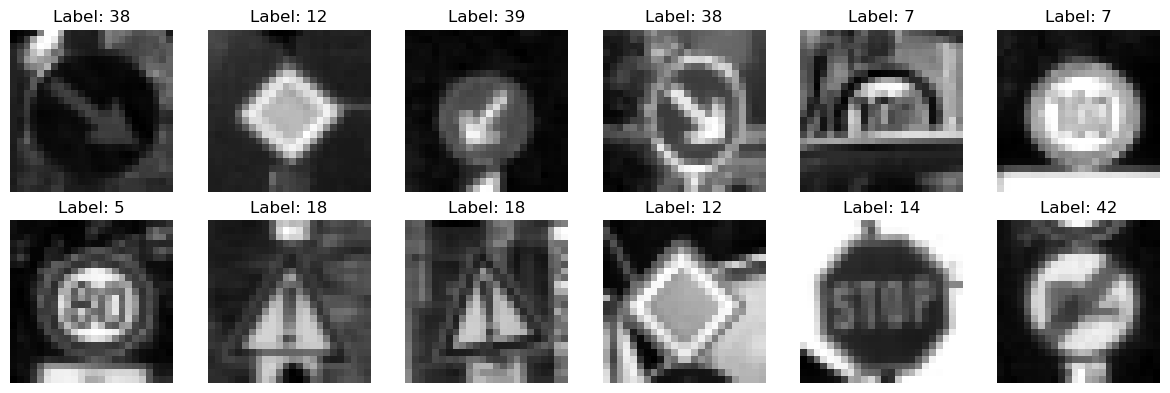

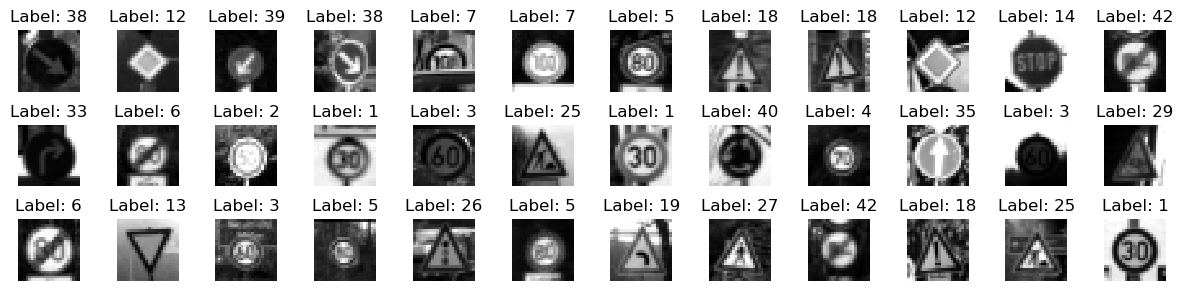

In [21]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

# Afficher et sauvegarder le premier ensemble d'images (taille moyenne)
display_and_save_images(x_train, y_train, range(12), columns=6, x_size=2, y_size=2, save_as='img/01-dataset-medium')

# Afficher et sauvegarder le second ensemble d'images (taille petite)
display_and_save_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1, save_as='img/02-dataset-small')

# Step 4 - Create model
We will now build a model and train it...

Some models :

In [22]:

# ------------------------------------------------------------------
# -- A simple model, for 24x24 or 48x48 images                    --
# ------------------------------------------------------------------
#
def get_model_01(lx,ly,lz):
    
    model = keras.models.Sequential()

    model.add( keras.layers.Input((lx,ly,lz)) )
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu' ))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


In [23]:
# ------------------------------------------------------------------
# -- A more sophisticated model, for 48x48 images                 --
# ------------------------------------------------------------------
#
def get_model_02(lx,ly,lz):
    model = keras.models.Sequential()
    
    model.add( keras.layers.Input((lx,ly,lz)) )
    
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

# Step 5 - Train the model
**Get the shape of my data :**

In [24]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [30]:
model = get_model_01(lx,ly,lz)

model.summary()

model.compile(optimizer = 'adam',
              loss      = 'sparse_categorical_crossentropy',
              metrics   = ['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 22, 22, 96)        960       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 11, 11, 96)        0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 11, 11, 96)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 9, 9, 192)         166080    
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 4, 4, 192)         0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 4, 4, 192)        

**Train it :**

In [31]:
start_time = time.time()

x_train, y_train = shuffle(x_train, y_train)

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=fit_verbosity,
                    validation_data=(x_test, y_test))

end_time = time.time()
print(f"Durée d'entraînement: {end_time - start_time} secondes")


Epoch 1/5
123/123 [==============================] - 14s 104ms/step - loss: 3.0582 - accuracy: 0.1973 - val_loss: 1.9327 - val_accuracy: 0.4505
Epoch 2/5
123/123 [==============================] - 13s 109ms/step - loss: 1.2648 - accuracy: 0.6363 - val_loss: 0.9588 - val_accuracy: 0.7419
Epoch 3/5
123/123 [==============================] - 14s 111ms/step - loss: 0.6614 - accuracy: 0.8069 - val_loss: 0.6717 - val_accuracy: 0.8428
Epoch 4/5
123/123 [==============================] - 14s 110ms/step - loss: 0.4224 - accuracy: 0.8737 - val_loss: 0.5672 - val_accuracy: 0.8705
Epoch 5/5
123/123 [==============================] - 13s 109ms/step - loss: 0.3170 - accuracy: 0.9066 - val_loss: 0.4671 - val_accuracy: 0.8943
Durée d'entraînement: 67.95736765861511 secondes


# Step 5 - Evaluate

In [32]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.8943


In [33]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.4671
Test accuracy  : 0.8943
